# Comparing `smoothing_spline` with R's `smooth.spline`

This document demonstrates the usage of the `smoothing_spline` package and compares it with the standard `smooth.spline` function in R. We will use the `Bikeshare` dataset from the `ISLP` package.

## Setup

First, we need to import the necessary libraries and load the `rpy2` extension to run R code directly in this notebook.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from ISLP import load_data
from smoothing_spline import SplineFitter

%load_ext rpy2.ipython

Error importing in API mode: ImportError("dlopen(/Users/jonathantaylor/git-repos/ISLP/ISLP/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <05EE76C0-33BF-3D4C-BC56-84005241BC88> /Users/jonathantaylor/git-repos/ISLP/ISLP/.venv/lib/python3.12/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.


## Loading the Data

We will use the `Bikeshare` dataset, which contains daily counts of bike rentals in Washington D.C.

In [3]:
Bike = load_data('Bikeshare')
Bike.head()

,season,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,bikers
0,1,Jan,1,0,0,6,0,clear,0.24,0.2879,0.81,0.0,3,13,16
1,1,Jan,1,1,0,6,0,clear,0.22,0.2727,0.80,0.0,8,32,40
2,1,Jan,1,2,0,6,0,clear,0.22,0.2727,0.80,0.0,5,27,32
3,1,Jan,1,3,0,6,0,clear,0.24,0.2879,0.75,0.0,3,10,13
4,1,Jan,1,4,0,6,0,clear,0.24,0.2879,0.75,0.0,0,1,1


We will focus on the relationship between the hour of the day (`hr`) and the number of bikers (`bikers`). Since `hr` is categorical in the original dataset but represents time, we convert it to numeric.

In [4]:
# 'bikers' is 'cnt' in the original dataset, ISLP might have renamed it or we use 'cnt'
if 'bikers' not in Bike.columns:
    Bike['bikers'] = Bike['cnt']

hr_numeric = pd.to_numeric(Bike['hr'])
bikers = Bike['bikers']

# Sort by hour for cleaner plotting lines
sorted_idx = np.argsort(hr_numeric)
x_plot = hr_numeric.iloc[sorted_idx].unique()

## Fitting Smoothing Splines

### 1. Using `smoothing_spline` (Python)

We fit a smoothing spline with a specified degrees of freedom ($df=5$).

In [6]:
# Fit model
spl_py = SplineFitter(x=hr_numeric, df=5)
spl_py.fit(bikers)

# Predict
y_py = spl_py.predict(x_plot)

### 2. Using `smooth.spline` (R)

We fit the same model using R. We transfer the data to R and run the `smooth.spline` function.

In [7]:
%%R -i hr_numeric -i bikers -o y_r
# Fit model in R
fit_r <- smooth.spline(hr_numeric, bikers, df=5)

# Predict at unique hours
# unique() in R returns unsorted, but we want to match x_plot order
x_vals <- sort(unique(hr_numeric))
pred_r <- predict(fit_r, x_vals)
y_r <- pred_r$y

### Comparison

Let's visualize the results. They should be nearly identical.

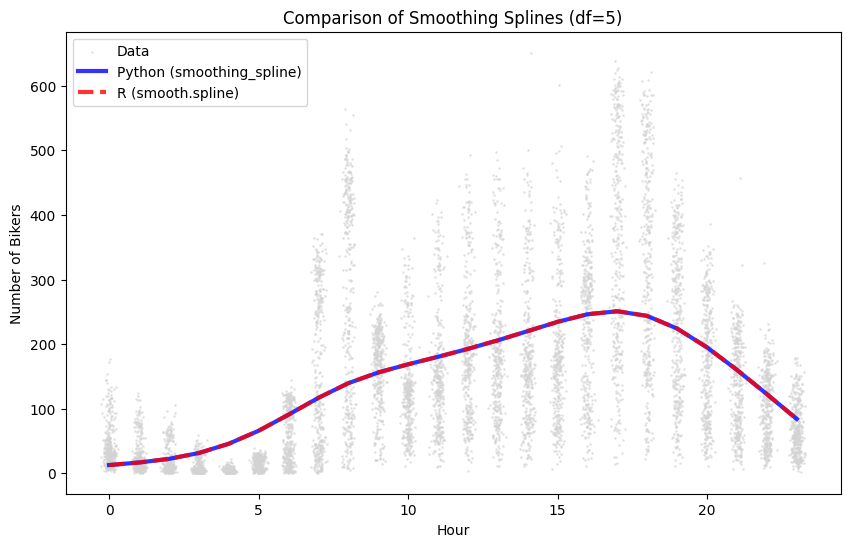

Mean Absolute Difference: 0.003859


In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(hr_numeric + np.random.normal(0, 0.1, len(hr_numeric)), bikers, 
            s=1, c='lightgray', alpha=0.5, label='Data')
ax.plot(x_plot, y_py, 'b-', lw=3, label='Python (smoothing_spline)', alpha=0.8)
ax.plot(x_plot, y_r, 'r--', lw=3, label='R (smooth.spline)', alpha=0.8)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Bikers")
ax.set_title("Comparison of Smoothing Splines (df=5)")
ax.legend()
plt.show()

# Numerical comparison
# Note: R might handle repeated x values slightly differently (using weights)
# smoothing_spline handles them naturally in the basis construction.
diff = np.mean(np.abs(y_py - y_r))
print(f"Mean Absolute Difference: {diff:.6f}")

## Speed Comparison

We will compare the execution time for fitting the model.

In [10]:
# Python Timing
t_py = %timeit -o -n 10 -r 3 SplineFitter(x=hr_numeric, df=10).fit(bikers)

# R Timing

3.38 ms ± 853 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [12]:
%%R -i hr_numeric -i bikers
library(microbenchmark)
# R Timing
microbenchmark(
  smooth.spline(hr_numeric, bikers, df=10),
  times=10
)

Unit: milliseconds
                                       expr      min      lq     mean   median
 smooth.spline(hr_numeric, bikers, df = 10) 1.224752 1.25706 1.340593 1.304067
     uq      max neval
 1.4555 1.532006    10


## Automatic Tuning with GCV

One of the key features of smoothing splines is the automatic selection of the smoothing parameter ($\lambda$) using Generalized Cross-Validation (GCV).

### In R

R's `smooth.spline` uses GCV (or CV) by default if `df` and `spar` are not specified.

In [13]:
%%R
fit_gcv <- smooth.spline(hr_numeric, bikers, cv=FALSE) # cv=FALSE implies GCV
cat("Selected df (R):", fit_gcv$df, "
")
cat("Selected lambda (R):", fit_gcv$lambda, "
")

Selected df (R): 23.09998 
Selected lambda (R): 9.504108e-05 


### In Python (smoothing_spline)

The `smoothing_spline` package also supports finding $\lambda$ that minimizes the GCV score.
*Note: As of the current version, GCV minimization might need to be called explicitly or via a helper if not the default fit method. Let's demonstrate how to use the underlying GCV score function.*

In [17]:
# We can sweep over a range of lambda values to find the minimum GCV
from scipy.optimize import minimize_scalar

# Initialize fitter with data
# Note: We use the internal C++ fitter for speed if available
fitter = SplineFitter(x=hr_numeric, knots=np.unique(hr_numeric))
fitter.fit(bikers)
# Access the internal C++ object for GCV calculation
cpp_fitter = fitter._cpp_fitter

# Define objective function
def gcv_objective(log_lam):
    lam = 10**log_lam
    # Scale lambda as the fitter expects scaled lambda if x was scaled
    # The python wrapper scales lambda by x_scale^3 before passing to C++ fit
    # But compute_df and fit in C++ take the value passed directly.
    # The Python .fit() does: lam_scaled = self.lamval / self.x_scale_**3
    # We want to optimize 'lamval'.
    
    lam_scaled = lam / fitter.fitter_.x_scale_**3
    return cpp_fitter.gcv_score(lam_scaled, bikers.values)

# Optimize
# Search range for log10(lambda)
res = minimize_scalar(gcv_objective, bounds=(-5, 5), method='bounded')
best_lam = 10**res.x
print(f"Selected lambda (Python): {best_lam}")

# Get corresponding df
best_lam_scaled = best_lam / fitter.fitter_.x_scale_**3
best_df = cpp_fitter.compute_df(best_lam_scaled)
print(f"Selected df (Python): {best_df}")

AttributeError: 'SplineFitter' object has no attribute 'fitter_'

We can now fit the final model with the optimal parameters.

In [ ]:
spl_opt = SplineFitter(lamval=best_lam)
spl_opt.fit(hr_numeric, bikers)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(hr_numeric + np.random.normal(0, 0.1, len(hr_numeric)), bikers, 
            s=1, c='lightgray')
ax.plot(x_plot, spl_opt.predict(x_plot), 'g-', lw=3, label=f'Optimal GCV (df={best_df:.2f})')
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Bikers")
ax.legend()
plt.show()

## Another Example: Log-Transformation

The relationship between hours and bikers might be better modeled on a log scale, as counts are non-negative and variance often increases with the mean.

In [ ]:
# Fit model on log(bikers)
log_bikers = np.log(bikers + 1) # Add 1 to avoid log(0)
spl_log = SplineFitter(df=5)
spl_log.fit(hr_numeric, log_bikers)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(hr_numeric + np.random.normal(0, 0.1, len(hr_numeric)), log_bikers, 
            s=1, c='lightgray')
ax.plot(x_plot, spl_log.predict(x_plot), 'purple', lw=3, label='Log-Smoothing Spline (df=5)')
ax.set_xlabel("Hour")
ax.set_ylabel("Log(Number of Bikers + 1)")
ax.legend()
plt.show()